# PCA dla `measures.csv` (SVD vs. sklearn)

Analiza PCA na macierzy 250×5 (po usunięciu kolumny `brozek`). Porównujemy wynik implementacji opartej o **SVD** z gotową implementacją **`scikit-learn`**.

## Plan
1. Wczytanie danych
2. Usunięcie kolumny `brozek`
3. Standaryzacja zmiennych
4. PCA przez **SVD**
5. PCA w **sklearn**
6. Porównanie wyników
7. Wykresy: scree + wariancja skumulowana + biplot (PC1 vs PC2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

file_path = 'measures.csv'  # ścieżka do pliku w środowisku
df = pd.read_csv(file_path)
df.head()

,age,height,weight,chest,abdom,brozek
0,62,71.50,167.50,97.6,91.5,23.7
1,69,70.50,215.50,113.7,107.6,29.1
2,44,69.50,179.75,101.9,93.2,18.1
3,54,70.50,153.25,99.0,91.8,12.7
4,40,74.25,170.50,98.9,90.4,17.4


In [2]:
df.shape, df.columns.tolist()

((250, 6), ['age', 'height', 'weight', 'chest', 'abdom', 'brozek'])

## Usunięcie `brozek` i standaryzacja

In [3]:
# Usuwamy kolumnę `brozek`, zostaje 5 cech
X = df.drop(columns=['brozek']).values
cols = df.drop(columns=['brozek']).columns.tolist()

# Standaryzacja: każda cecha ma średnią 0 i odchylenie 1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std.mean(axis=0), X_std.std(axis=0, ddof=0)

(array([-1.42108547e-17,  1.06936682e-15, -1.70530257e-16, -7.95807864e-16,
         1.42108547e-17]),
 array([1., 1., 1., 1., 1.]))

## PCA przez SVD

In [4]:
# Rozkład SVD macierzy standaryzowanej
U, S, Vt = np.linalg.svd(X_std, full_matrices=False)

# Wartości własne kowariancji = S^2 / (n-1)
n_samples = X_std.shape[0]
eigenvalues_svd = (S**2) / (n_samples - 1)

# Wektory własne (ładunki składowych) = V (wiersze Vt)
components_svd = Vt

explained_ratio_svd = eigenvalues_svd / eigenvalues_svd.sum()
pd.DataFrame({
    'eigenvalue': eigenvalues_svd[:5],
    'explained_ratio': explained_ratio_svd[:5]
}, index=[f'PC{i+1}' for i in range(5)])

,eigenvalue,explained_ratio
PC1,2.956655,0.588966
PC2,1.311131,0.261177
PC3,0.624366,0.124374
PC4,0.088027,0.017535
PC5,0.039901,0.007948


## PCA w `scikit-learn`

In [5]:
pca = PCA()
X_pca = pca.fit_transform(X_std)
pd.DataFrame({
    'eigenvalue_sklearn': pca.explained_variance_,
    'explained_ratio_sklearn': pca.explained_variance_ratio_
}, index=[f'PC{i+1}' for i in range(pca.n_components_)])

,eigenvalue_sklearn,explained_ratio_sklearn
PC1,2.956655,0.588966
PC2,1.311131,0.261177
PC3,0.624366,0.124374
PC4,0.088027,0.017535
PC5,0.039901,0.007948


## Porównanie wyników (SVD vs. sklearn)

In [6]:
comparison = pd.DataFrame({
    'eigenvalue_svd': eigenvalues_svd,
    'eigenvalue_sklearn': pca.explained_variance_,
    'ratio_svd': explained_ratio_svd,
    'ratio_sklearn': pca.explained_variance_ratio_
}, index=[f'PC{i+1}' for i in range(len(eigenvalues_svd))])
comparison

,eigenvalue_svd,eigenvalue_sklearn,ratio_svd,ratio_sklearn
PC1,2.956655,2.956655,0.588966,0.588966
PC2,1.311131,1.311131,0.261177,0.261177
PC3,0.624366,0.624366,0.124374,0.124374
PC4,0.088027,0.088027,0.017535,0.017535
PC5,0.039901,0.039901,0.007948,0.007948


## Wykresy

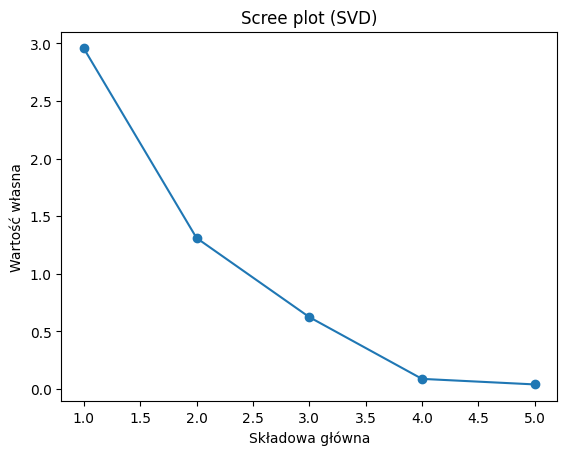

In [7]:
# Scree plot (wartości własne)
plt.figure()
plt.plot(range(1, len(eigenvalues_svd)+1), eigenvalues_svd, marker='o')
plt.xlabel('Składowa główna')
plt.ylabel('Wartość własna')
plt.title('Scree plot (SVD)')
plt.show()

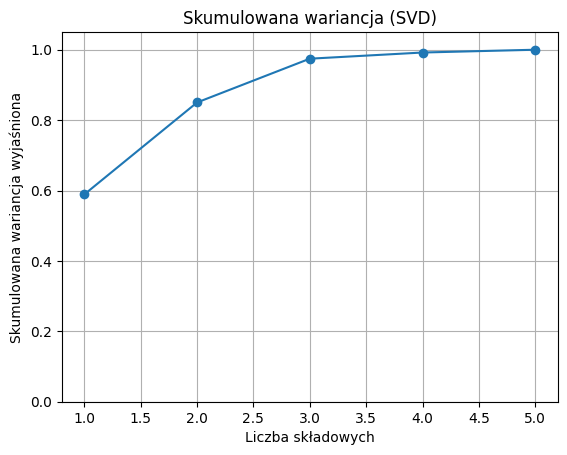

In [8]:
# Wariancja skumulowana
cum = np.cumsum(explained_ratio_svd)
plt.figure()
plt.plot(range(1, len(cum)+1), cum, marker='o')
plt.xlabel('Liczba składowych')
plt.ylabel('Skumulowana wariancja wyjaśniona')
plt.title('Skumulowana wariancja (SVD)')
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

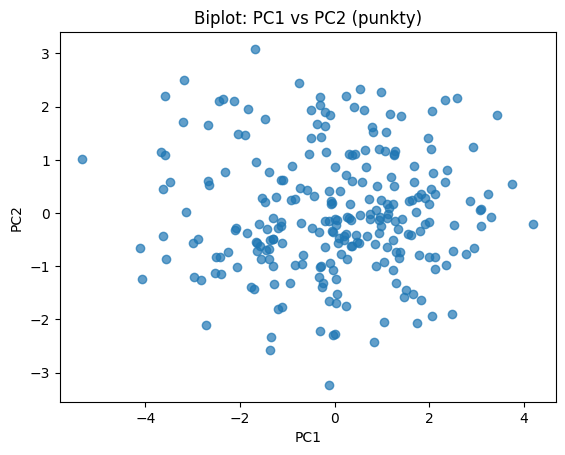

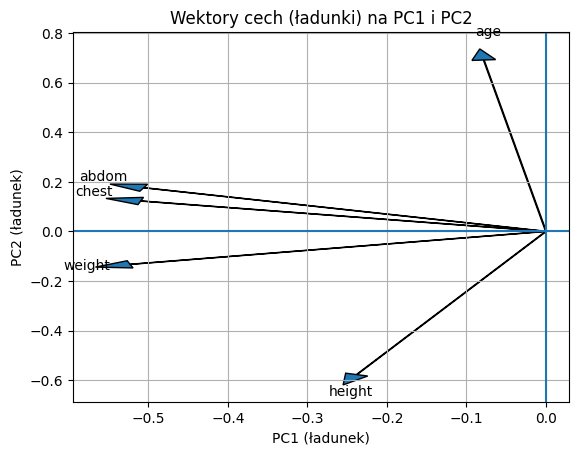

In [9]:
# Biplot dla PC1 i PC2
pc_scores = U[:, :2] * S[:2]
plt.figure()
plt.scatter(pc_scores[:,0], pc_scores[:,1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot: PC1 vs PC2 (punkty)')
plt.show()

# Ładunki (wektory cech) na tych składowych
loadings = components_svd[:2].T
plt.figure()
origin = np.zeros((2,))
for i, name in enumerate(cols):
    plt.arrow(0, 0, loadings[i,0], loadings[i,1], head_width=0.03, length_includes_head=True)
    plt.text(loadings[i,0]*1.07, loadings[i,1]*1.07, name)
plt.axhline(0)
plt.axvline(0)
plt.xlabel('PC1 (ładunek)')
plt.ylabel('PC2 (ładunek)')
plt.title('Wektory cech (ładunki) na PC1 i PC2')
plt.grid(True)
plt.show()